In [1]:
from datasets import load_dataset

/home/yafqak/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sst2_dataset = load_dataset("stanfordnlp/sst2")

In [3]:
train = sst2_dataset["train"]

In [4]:
train[:3]

{'idx': [0, 1, 2],
 'sentence': ['hide new secretions from the parental units ',
  'contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature '],
 'label': [0, 0, 1]}

In [5]:
pandas_train = train.to_pandas()[['sentence', 'label']]

In [6]:
pandas_train['sentence'][6]

'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . '

In [7]:
import string
remove_punctuation = lambda s : s.translate(str.maketrans('', '', string.punctuation))

In [8]:
pandas_train['sentence'] = pandas_train['sentence'].apply(remove_punctuation)

In [9]:
import pandas as pd

In [10]:
word_to_labels = {}
for _, row in pandas_train.iterrows():
    for word in row['sentence'].split():
        if word not in word_to_labels:
            word_to_labels[word] = [0] * 2
        word_to_labels[word][row['label']] += 1

word_freq_df = pd.DataFrame.from_dict(word_to_labels, orient='index')

In [11]:
word_freq_df

,0,1
hide,12,2
new,252,432
secretions,3,0
from,929,930
the,12426,14779
...,...,...
featherweight,0,1
koshashvili,0,1
symbolically,0,1
iranianamerican,0,1


In [12]:
word_freq_df['n'] = word_freq_df.sum(axis=1)

In [13]:
word_freq_df

,0,1,n
hide,12,2,14
new,252,432,684
secretions,3,0,3
from,929,930,1859
the,12426,14779,27205
...,...,...,...
featherweight,0,1,1
koshashvili,0,1,1
symbolically,0,1,1
iranianamerican,0,1,1


In [14]:
word_freq_df['p_0'], word_freq_df['p_1'] = word_freq_df[0] / word_freq_df['n'], word_freq_df[1] / word_freq_df['n']

In [15]:
word_freq_df

,0,1,n,p_0,p_1
hide,12,2,14,0.857143,0.142857
new,252,432,684,0.368421,0.631579
secretions,3,0,3,1.000000,0.000000
from,929,930,1859,0.499731,0.500269
the,12426,14779,27205,0.456754,0.543246
...,...,...,...,...,...
featherweight,0,1,1,0.000000,1.000000
koshashvili,0,1,1,0.000000,1.000000
symbolically,0,1,1,0.000000,1.000000
iranianamerican,0,1,1,0.000000,1.000000


In [16]:
word_freq_df.loc['funny']

0       252.000000
1       853.000000
n      1105.000000
p_0       0.228054
p_1       0.771946
Name: funny, dtype: float64

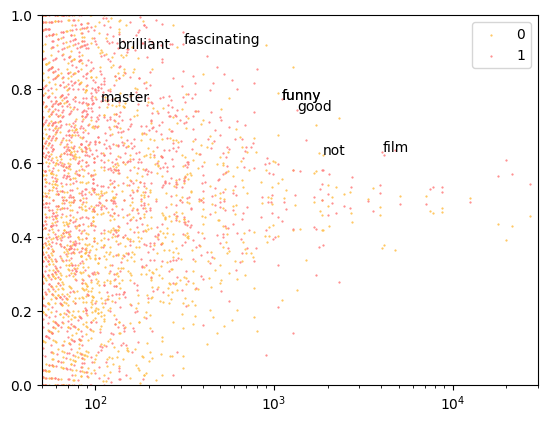

In [17]:
from matplotlib import pyplot as plt

plt.xscale("log")
ax = plt.gca()
ax.set_xlim([5e1, 3e4])
ax.set_ylim([0, 1])
plt.scatter(x=word_freq_df['n'], y=word_freq_df['p_0'], s=0.3, label='0', color='#FFC04D')
plt.scatter(x=word_freq_df['n'], y=word_freq_df['p_1'], s=0.3, label='1', color='#FF8080')
words = ["funny", "not", "good", "film", "master", "brilliant", "fascinating"]
for word in words:
    ax.annotate(word, (word_freq_df.loc[word]['n'], max(word_freq_df.loc[word]['p_0'], word_freq_df.loc[word]['p_1'])))
ax.annotate("funny", (1105, 0.7719457013574661))
plt.legend()

In [18]:
from scipy.stats import norm
import numpy as np

alpha = 1 - 0.01 / 14700
z_star = norm.ppf(alpha)

boundary = lambda n : z_star / (2 * np.sqrt(n)) + 1/2

In [19]:
x_vals = np.linspace(0, 3e4, 10**5)
y_vals = boundary(x_vals)

/tmp/ipykernel_31132/865305046.py:7: RuntimeWarning: divide by zero encountered in divide
  boundary = lambda n : z_star / (2 * np.sqrt(n)) + 1/2


In [25]:
max_p = word_freq_df[['p_1', 'p_0']].max(axis=1)
word_freq_df['boundary'] = boundary(word_freq_df['n'])
word_freq_df['isArtifact'] = max_p > word_freq_df['boundary']
word_freq_df['max_p'] = word_freq_df[['p_1', 'p_0']].max(axis=1)
word_freq_df['diff'] = abs(word_freq_df['boundary'] - word_freq_df['max_p'])
# word_freq_df[['n', 'p_0', 'p_1', 'boundary', 'isArtifact']].sort_values(by=['isArtifact', 'n'], ascending=False).to_csv("sst2_artifacts.csv")

In [28]:
word_freq_df.sort_values(by=['isArtifact', 'diff'], ascending=False).to_csv("sst2_artifacts.csv")

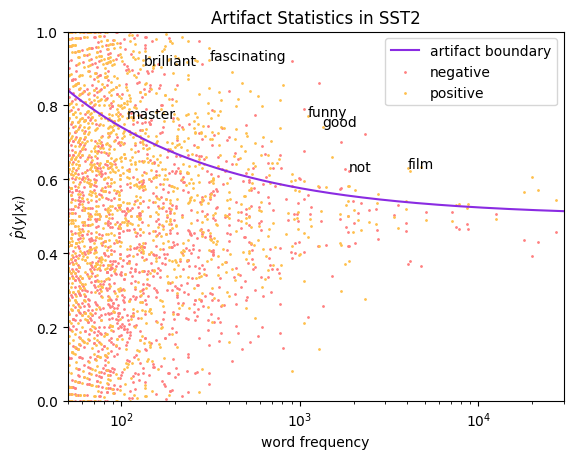

In [22]:
ax = plt.gca()
ax.set_xlim([5e1, 3e4])
ax.set_ylim([0, 1])
plt.xscale("log")
plt.title("Artifact Statistics in SST2")
plt.xlabel("word frequency")
plt.ylabel("$\hat{p}(y|x_i)$")
plt.plot(x_vals, y_vals, label=f'artifact boundary', color="#8A2BE2")
plt.scatter(x=word_freq_df['n'], y=word_freq_df['p_0'], s=1, label='negative', color='#FF8080')
plt.scatter(x=word_freq_df['n'], y=word_freq_df['p_1'], s=1, label='positive', color='#FFC04D')
words = ["funny", "not", "good", "film", "master", "brilliant", "fascinating"]
for word in words:
    ax.annotate(word, (word_freq_df.loc[word]['n'], max(word_freq_df.loc[word]['p_0'], word_freq_df.loc[word]['p_1'])))
plt.legend()

In [23]:
word_freq_df.to_csv("~/cse547/final-project/sst2_word_freqs.csv")

In [24]:
# 